In [1]:
using Plots
using LaTeXStrings
using FilePathsBase
using Dates
using Statistics

In [2]:
include("src/constants.jl")
include("src/main.jl")
include("src/solver_code.jl")
include("src/piecewise_polytrope_eos_cgs.jl")
using .MainModule
using .SolverCode
using .PiecePoly
# Typical scale
println("length scale: ", unit_l, " cm")
println("energy density scale: ", ε_ref, " g/cm^3")
println("energy density scale: ", ε_ref*gcm3_to_MeVfm3/1000, " GeV/fm^3")

length scale: 147661.32831248126 cm
energy density scale: 6.175945314552516e17 g/cm^3
energy density scale: 346.44512454233296 GeV/fm^3


In [3]:
# ファイルパスを指定
file_path = "data/eos_HQC18_gv100H160.txt"
P = []
e = []
cs2 = [] 
# ファイルを行単位で読み込む
lines = readlines(file_path)
println(lines[1])
for line in lines[2:end]
    # 行をスペースで分割して各値を数値に変換
    values = parse.(Float64, split(line))
    push!(P, values[2]) 
    push!(e, values[4]) 
    push!(cs2, values[5].^2) 
end
file_path2 = "data/eos_HQC18_gv080H150.txt"
P2 = []
e2 = []
lines = readlines(file_path2)
for line in lines[2:end]
    values = parse.(Float64, split(line))
    push!(P2, values[2]) 
    push!(e2, values[4])
end
file_path3 = "data/eos_HQC18_gv050H140.txt"
P3 = []
e3 = []
lines = readlines(file_path3)
for line in lines[2:end]
    values = parse.(Float64, split(line))
    push!(P3, values[2]) 
    push!(e3, values[4])
end

 muB (MeV)    P (MeV/fm^3)           nB/n0    e (MeV/fm^3)              cs


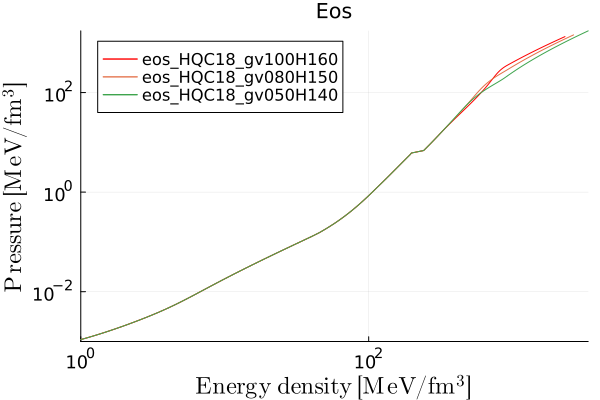

In [4]:
mono_e, mono_P = MainModule.make_eos_monotonic(e, P)
mono_e2, mono_P2 = MainModule.make_eos_monotonic(e2, P2)
mono_e3, mono_P3 = MainModule.make_eos_monotonic(e3, P3)

# グラフの描画
plot(mono_e, mono_P;
    label="eos_HQC18_gv100H160", 
    xlabel=L"\mathrm{Energy\ density\ [MeV/fm^3]}",xlabelfontsize=16,
    ylabel=L"\mathrm{Pressure\ [MeV/fm^3]}", ylabelfontsize=16,
    title="Eos",
    legend=:topleft,
    xscale=:log10,  # x軸を対数スケールに変更
    yscale=:log10,  # y軸を対数スケールに変更)
    xtickfontsize=12,
    ytickfontsize=12,
    xlims=(1,mono_e3[end]),
    ylims=(1e-3, mono_P3[end]),
    color=:red
)
plot!(mono_e2, mono_P2; label=splitext(basename(file_path2))[1])
plot!(mono_e3, mono_P3; label=splitext(basename(file_path3))[1])
# 凡例のフォントサイズを変更
plot!(legendfontsize=11)  # 凡例のフォントサイズを指定

In [5]:
file_path_params = "data/parameters_PiecewisePolytropeEoS.txt"
logP_dyncm2= []
Gamma1 = []
Gamma2 = []
Gamma3 = []
# ファイルを行単位で読み込む
lines = readlines(file_path_params)
println(lines[1])
for line in lines[2:end]
    # 行をスペースで分割して各値を数値に変換
    values = parse.(Float64, split(line))
    push!(logP_dyncm2, values[1]) 
    push!(Gamma1, values[2]) 
    push!(Gamma2, values[3]) 
    push!(Gamma3, values[4]) 
end
Gammas = []
for i in 1:length(Gamma1)
    push!(Gammas, [Gamma1[i], Gamma2[i], Gamma3[i]])
end
println("size of Gammas: (", size(Gammas, 1), ", ", size(Gammas[1],1), ")")

# log10(p1 [dyn/cm2]) Gamma1 Gamma2 Gamma3
size of Gammas: (34, 3)


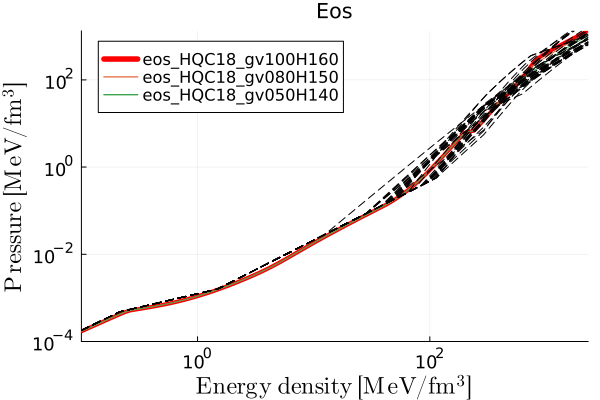

In [6]:
plot(mono_e, mono_P;
    label="eos_HQC18_gv100H160", 
    xlabel=L"\mathrm{Energy\ density\ [MeV/fm^3]}",xlabelfontsize=16,
    ylabel=L"\mathrm{Pressure\ [MeV/fm^3]}", ylabelfontsize=16,
    title="Eos",
    legend=:topleft,
    xscale=:log10,  # x軸を対数スケールに変更
    yscale=:log10,  # y軸を対数スケールに変更)
    xtickfontsize=12,
    ytickfontsize=12,
    linewidth=4,
    xlims=(0.1,mono_e[end]), ylims=(1e-4, mono_P[end]),
    color=:red,
)
plot!(mono_e2, mono_P2;
    label=splitext(basename(file_path2))[1],
)
plot!(mono_e3, mono_P3;
    label=splitext(basename(file_path3))[1]
)

ε_arr = []
p_arr = []
for i in 1:length(logP_dyncm2)
    rho_lim_all, a_all, K_all, Gamma_all = PiecePoly.get_all_params(logP_dyncm2[i], Gammas[i])
    ε_temp, p_temp = PiecePoly.make_polyEos(rho_lim_all, a_all, K_all, Gamma_all)
    ε, p = MainModule.make_eos_monotonic(ε_temp, p_temp)
    push!(ε_arr, ε)
    push!(p_arr, p)
    # println(length(p_temp)-length(p))
    plot!(ε[1:10:end].*gcm3_to_MeVfm3, p[1:10:end].*gcm3_to_MeVfm3;
        label=nothing,
        color=:black,
        linestyle=:dash,
    )
end
plot!(legendfontsize=11)  # 凡例のフォントサイズを指定

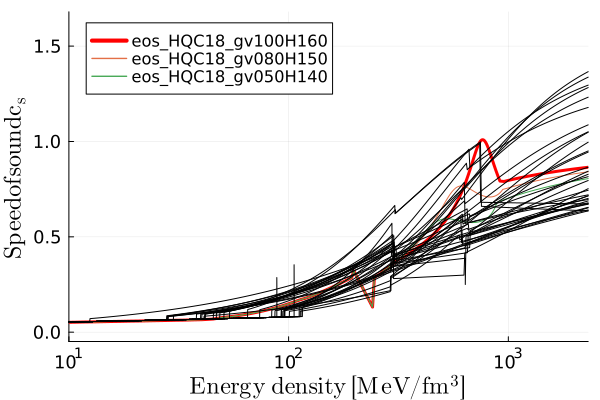

In [7]:
plot(mono_e[2:end],
     [sqrt((mono_P[i]-mono_P[i-1])/(mono_e[i]-mono_e[i-1])) for i in 2:length(mono_P)];
     label="eos_HQC18_gv100H160", 
     xlabel=L"\mathrm{Energy\ density\ [MeV/fm^3]}",xlabelfontsize=16,
     ylabel=L"\mathrm{Speed of sound c_s}", ylabelfontsize=16,
     legend=:topleft,
     xscale=:log10,  # x軸を対数スケールに変更
     yscale=:identity,
     xlims=(10,mono_e[end]),
     xtickfontsize=12,
     ytickfontsize=12,
     lw=3,
     color=:red,
)
plot!(mono_e2[2:end],
     [sqrt((mono_P2[i]-mono_P2[i-1])/(mono_e2[i]-mono_e2[i-1])) for i in 2:length(mono_P2)];
     label=splitext(basename(file_path2))[1]
)
plot!(mono_e3[2:end],
     [sqrt((mono_P3[i]-mono_P3[i-1])/(mono_e3[i]-mono_e3[i-1])) for i in 2:length(mono_P3)];
     label=splitext(basename(file_path3))[1]
)
for i in 1:1:length(logP_dyncm2)
    ε = ε_arr[i]
    p = p_arr[i]
    cs2 = [(p[i]-p[i-1])/(ε[i]-ε[i-1]) for i in 2:length(p)]
    plot!(ε[2:end].*gcm3_to_MeVfm3, sqrt.(cs2[1:end]);
        label=nothing,
        color=:black,
    )
end
# 凡例のフォントサイズを変更
plot!(legendfontsize=11)  # 凡例のフォントサイズを指定

In [8]:
R_arr = []
M_arr = []
Λ_arr = []

RMT, sol = MainModule.out_RMT(mono_e*MeVfm3_to_gcm3/ε_ref, mono_P*MeVfm3_to_gcm3/ε_ref, debug=false)
push!(R_arr, RMT[1])
push!(M_arr, RMT[2])
push!(Λ_arr, RMT[3])
RMT2, sol2 = MainModule.out_RMT(mono_e2*MeVfm3_to_gcm3/ε_ref, mono_P2*MeVfm3_to_gcm3/ε_ref)
push!(R_arr, RMT2[1])
push!(M_arr, RMT2[2])
push!(Λ_arr, RMT2[3])
RMT3, sol3 = MainModule.out_RMT(mono_e3*MeVfm3_to_gcm3/ε_ref, mono_P3*MeVfm3_to_gcm3/ε_ref)
push!(R_arr, RMT3[1])
push!(M_arr, RMT3[2])
push!(Λ_arr, RMT3[3])

elapsed_arr = []
for i in 1:1:length(logP_dyncm2)
    ε = ε_arr[i]
    p = p_arr[i]
    
    start_time = now()
    RMT, _ = MainModule.out_RMT(ε./ε_ref, p./ε_ref, debug=false)
    end_time = now()
    elapsed_ms = Dates.value(end_time - start_time)
    push!(elapsed_arr, elapsed_ms)
    
    push!(R_arr, RMT[1])
    push!(M_arr, RMT[2])
    push!(Λ_arr, RMT[3])
end
println(sum(elapsed_arr)/1000, " sec")
println(mean(elapsed_arr)/1000, " ± ", std(elapsed_arr)/sqrt(length(logP_dyncm2))/1000 , " sec/RMT")

283.377 sec
8.334617647058824 ± 1.1007433106920723 sec/RMT


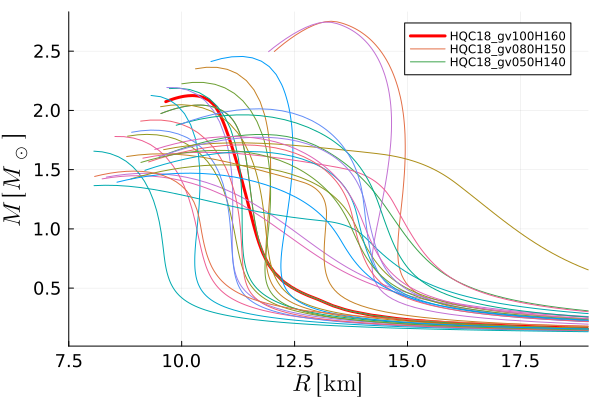

In [9]:
# 最初のプロットを作成
R = R_arr[1]
M = M_arr[1]
Λ = Λ_arr[1]
p = plot(R, M;
    label="HQC18_gv100H160",
    xlims=(7.5, 19),
    legend=:topright,
    lw=3,
    color=:red,
    xlabel=L"R\ [\mathrm{km}]", xlabelfontsize=16,
    ylabel=L"M\ [M_\odot]", ylabelfontsize=16,
    xtickfontsize=12,
    ytickfontsize=12,
)
R = R_arr[2]
M = M_arr[2]
Λ = Λ_arr[2]
plot!(p, R, M;
    label=replace(splitext(basename(file_path2))[1], "eos_" => "")
)

R = R_arr[2]
M = M_arr[2]
Λ = Λ_arr[2]
plot!(p, R, M;
    label=replace(splitext(basename(file_path3))[1], "eos_" => "")
)

# 4 から length(logP_dyncm2) まで繰り返しプロットに追加
for i in 4:1:length(logP_dyncm2)
    R = R_arr[i]
    M = M_arr[i]
    Λ = Λ_arr[i]
    plot!(p, R, M, label=nothing)  # 既存のプロットに追加
end
# プロットを表示
display(p)
# プロットをPDFで保存
# savefig(p, "PiecewisePolys_MR.pdf")

In [10]:
mono_P[end]*MeVfm3_to_gcm3/ε_ref

0.0038386454471161105

In [12]:
2.9e-6*ε_ref*gcm3_to_MeVfm3

1.0046908611727656